In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, absolute_import, division

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from GomokuBoard import GomokuBoard
from Heuristics import Heuristics
from GomokuTools import GomokuTools as gt
from HeuristicPolicy import HeuristicGomokuPolicy

In [4]:
from google.cloud import bigquery
import google.datalab.bigquery as bq

In [5]:
%load_ext google.cloud.bigquery

In [6]:
A,B,C,D,E,F,G,H,I, J, K, L, M, N, O, P, Q, R, S, T, U = \
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK, WHITE, EDGES = 0,1,2

from [Yixin vs Rudolf Dupszki](https://www.aiexp.info/ai-vs-human-gomoku-2.html), we have a nice threat sequence:

- Round1: Swap2, two more, +, Yixin white. 
- Round2: Swap2, two more, +, Yixin black.

In [7]:
# Round 1
# stones=gt.string_to_stones('l13k12m11n14o13k11j12k13k10j10i9j9j8k7h11l8i11m9n10m7l9l7n7m8m6k6n9n6k9i7j7k5')
# Round 2
stones=gt.string_to_stones('e10g8g5f5f6e7f7f8e8g9h10d9g10f10h8h9i9g7e9j8h11i12e11e12g11f11f12e13g13h14i10g14j9k8i8k4i7')

In [8]:
b = GomokuBoard(heuristics=Heuristics(kappa=3), N=20, stones=stones, disp_width=10)

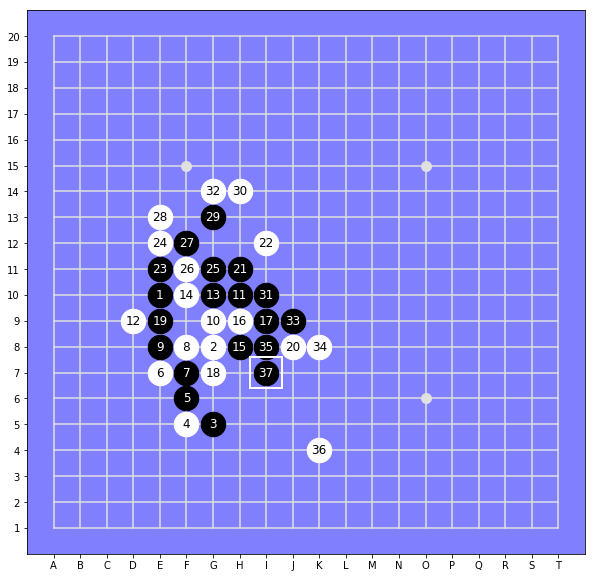

In [9]:
b.display()

# Reading psq files

In [10]:
file = open("games/0_0_8_2.psq", "r")
lines = [l.strip().split(',') for l in file]
stones = [(chr(64+int(x)), int(y)) for x,y,_ in lines[1:-4]]

In [11]:
print(stones)

[('J', 20), ('K', 20), ('J', 19), ('K', 19), ('J', 18), ('K', 18), ('J', 17), ('K', 17), ('K', 16), ('J', 16), ('M', 16), ('I', 15), ('H', 14), ('L', 15), ('H', 13), ('K', 15), ('J', 15), ('I', 14), ('L', 14), ('M', 17), ('I', 13), ('L', 18), ('M', 19), ('N', 18), ('L', 16), ('N', 16), ('O', 15), ('N', 17), ('N', 19), ('O', 17), ('L', 17), ('M', 18), ('O', 18), ('P', 17), ('Q', 17), ('N', 15), ('N', 14), ('O', 16), ('L', 19), ('M', 14), ('L', 13), ('Q', 18)]


In [12]:
b = GomokuBoard(heuristics=Heuristics(kappa=3), stones=stones, disp_width=10, N=20)

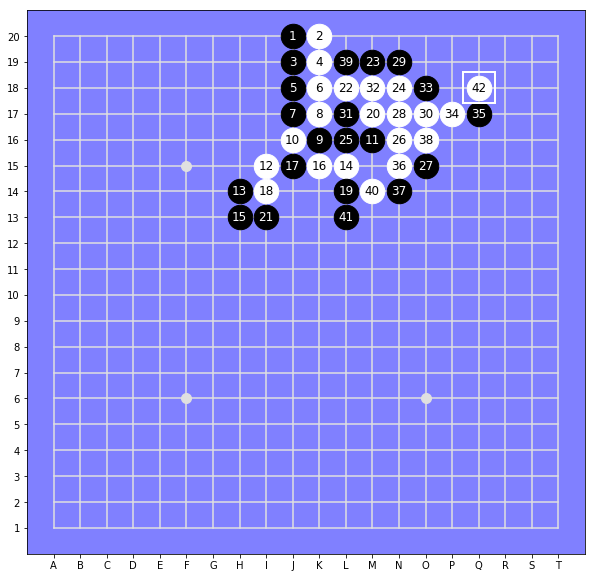

In [13]:
b.display()

---
# Gomocup 2018 data for upload to GCP

In [ ]:
def read_psq(filename):
    file = open(filename, "r")

    blob=file.read()
    lines=blob.split("\n")
    blob = blob.replace(",",";")

    head = lines[0]
    game = lines[1:-5]
    tail = lines[-5:]

    coords = [m.split(',') for m in game]
    stones = [(chr(int(x)+64),int(y)) for x,y,_ in coords]
    game = gt.stones_to_string(stones)    
    
    headers = [w.strip() for w in head.split(",")]

    filetype, dimensions=headers[0].split()

    assert(filetype=="Piskvorky")
    
    dim_x, dim_y = dimensions.split('x')
    dim_x, dim_y = int(dim_x), int(dim_y)

    h3, h4 = headers[1:]

    player1, player2 = tail[:2]

    t3=tail[2]
    t4, tournament = tail[3].split(",")

    return {
        'filetype': filetype,
        'dim_x': dim_x,
        'dim_y': dim_y,
        'h3': h3,
        'h4': h4,
        'player1': player1,
        'player2': player2,
        'game': game,
        't3': t3,
        't4': t4,
        'tournament': tournament,
        'blob': blob
    }

In [ ]:
res = read_psq("games/0_0_1_2.psq")
res

#### Concatenating psq files into a single CSV
Attention: This might take a while!!

Especially, 'Fastgame' takes about half an hour or so

In [ ]:
df = pd.DataFrame()
tournaments = ['Fastgame', 'Freestyle1', 'Freestyle2', 'Freestyle3', 'Freestyle4', 'Standard']

directory='/Users/wgiersche/Downloads/gomocup2018results/'+'Freestyle1'

files = [f for f in os.listdir(directory) if '.psq' in f]
for file in files:
    res = read_psq(directory + "/" + file)
    df = df.append(res, ignore_index=True)

In [ ]:
df.to_csv('Standard.csv')

In [ ]:
list(df.head()['game'])

#### Uploading into a single BigQuery Table

In [ ]:
%%bash
bq --location=US load --autodetect --source_format=CSV --replace gomoku.tournaments_tmp gs://gomoku-data/gomocup2018results/Freestyle1.csv
bq --location=US load --autodetect --source_format=CSV gomoku.tournaments_tmp gs://gomoku-data/gomocup2018results/Freestyle2.csv
bq --location=US load --autodetect --source_format=CSV gomoku.tournaments_tmp gs://gomoku-data/gomocup2018results/Freestyle3.csv
bq --location=US load --autodetect --source_format=CSV gomoku.tournaments_tmp gs://gomoku-data/gomocup2018results/Freestyle4.csv
bq --location=US load --autodetect --source_format=CSV gomoku.tournaments_tmp gs://gomoku-data/gomocup2018results/Standard.csv
bq --location=US load --autodetect --source_format=CSV gomoku.tournaments_tmp gs://gomoku-data/gomocup2018results/Fastgame.csv

In [ ]:
%%bigquery
select tournament, count(*) from `going-tfx.gomoku.tournaments_tmp` group by tournament

In [ ]:
%%writefile /tmp/transfer.sql
select tournament, "2018" as year, dim_x, dim_y, filetype, game, player1, player2, h3, h4, t3, t4, blob
from `going-tfx.gomoku.tournaments_tmp`

In [ ]:
_ = !cat /tmp/transfer.sql | bq --location=US query --replace --destination_table gomoku.tournaments --use_legacy_sql=false

---
# Preprocessing from BQ

In [14]:
%%bigquery
select * from `going-tfx.gomoku.tournaments` limit 10

,tournament,year,dim_x,dim_y,filetype,game,player1,player2,h3,h4,t3,t4,blob
0,Freestyle4,2018,20.0,20.0,Piskvorky,r5q3n2o5n6n5o4p4p5q6o6q7p6n7o7p8o9n8q4o8q8m6l5...,EGO.zip,RAPFI.zip,11:11,0,-1,1,Piskvorky 20x20; 11:11; 0\n18;5;0\n17;3;0\n14;...
1,Freestyle4,2018,20.0,20.0,Piskvorky,j20k20j19k19j18k18j17k17k16j16m16l15i15l14l13k...,EGO.zip,ALPHAGOMOKU.KOZARZEWSKI.zip,11:11,0,-1,1,Piskvorky 20x20; 11:11; 0\n10;20;0\n11;20;0\n1...
2,Freestyle3,2018,20.0,20.0,Piskvorky,h18h16m18m16g17g18i17f18i16e18i19d18c18f16i18i...,EGO.zip,STAHLFAUST.zip,11:11,0,-1,1,Piskvorky 20x20; 11:11; 0\n8;18;0\n8;16;0\n13;...
3,Freestyle2,2018,20.0,20.0,Piskvorky,h13h15d15c16k12d17j13e18b15f17g16e17g17c17b17e...,EGO.zip,GOFIVE.zip,11:11,0,-1,1,Piskvorky 20x20; 11:11; 0\n8;13;0\n8;15;0\n4;1...
4,Fastgame,2018,20.0,20.0,Piskvorky,j20k20i20l20h20m20n18m16n16m17m15l14o17n15o14o...,EGO.zip,TITO14.zip,11:11,0,-1,1,Piskvorky 20x20; 11:11; 0\n10;20;0\n11;20;0\n9...
5,Fastgame,2018,20.0,20.0,Piskvorky,r5q3n2o5n6n5o4p6p5n3q4p4q7p3o3o7n8l5o8m4k6m3m6...,EGO.zip,WINE18.zip,11:11,0,-1,1,Piskvorky 20x20; 11:11; 0\n18;5;0\n17;3;0\n14;...
6,Fastgame,2018,20.0,20.0,Piskvorky,b11e11d11f12d10d9e9f10f8g7b12c11b13b14c12f9f13...,EGO.zip,EULRING.zip,11:11,0,-1,1,Piskvorky 20x20; 11:11; 0\n2;11;0\n5;11;0\n4;1...
7,Fastgame,2018,20.0,20.0,Piskvorky,b20d20g20i20l20n20q20s20e19e16f16f15g14e14e15d...,EGO.zip,EULRING.zip,11:11,0,-1,1,Piskvorky 20x20; 11:11; 0\n2;20;0\n4;20;0\n7;2...
8,Fastgame,2018,20.0,20.0,Piskvorky,b11e11d11f12d10d9e9f10f8g7b12c11b13b14c12f9f13...,EGO.zip,FASTGOMOKU14.zip,11:11,0,-1,1,Piskvorky 20x20; 11:11; 0\n2;11;0\n5;11;0\n4;1...
9,Fastgame,2018,20.0,20.0,Piskvorky,j20k20i20l20h20m20n18l16m16l17l18k17n16j17i17n...,EGO.zip,RAPFI.zip,11:11,0,-1,1,Piskvorky 20x20; 11:11; 0\n10;20;0\n11;20;0\n9...


---
### Create Training data from a string rep

In [15]:
N=20

In [17]:
import apache_beam as beam
from GomokuData import data_from_game

In [18]:
heuristics = Heuristics(kappa=3.0)

In [19]:
def get_train_data_function(heuristics, N):
   
    def _floats_feature(value):
        return tf.train.Feature(float_list=tf.train.FloatList(value=value))

    def _create_train_data(recording):
        strrep =  recording['game']
        stones = gt.string_to_stones(strrep)
        board = GomokuBoard(heuristics, N, disp_width=8, stones=stones)
        policy = HeuristicGomokuPolicy(board, 2)
        return data_from_game(board, policy, heuristics)

    return _create_train_data

In [20]:
data_function = get_train_data_function(heuristics, N)

In [21]:
data = data_function({'game': 'e10g8g5f5f6e7f7f8e8g9h10d9'})

In [22]:
type(data), data[0].shape, data[1].shape

(tuple, (48, 22, 22, 2), (48, 22, 22, 1))

In [23]:
state2 = np.rollaxis(data[0][2], 2, 0)
list(state2)

[array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 

In [24]:
data[0].shape, data[1].shape

((48, 22, 22, 2), (48, 22, 22, 1))

In [25]:
s_and_q = list(zip(data[0], data[1]))
s_and_q[0][0].shape, s_and_q[0][1].shape

((22, 22, 2), (22, 22, 1))

In [26]:
N_p = N+2

feature_spec = {
    'state': tf.FixedLenFeature([N_p * N_p * 2], tf.float32),
    'qvalue': tf.FixedLenFeature([N_p * N_p], tf.float32)
}

In [27]:
def _floats_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [28]:
tfr_filename = "deleteme.tfr"
with tf.python_io.TFRecordWriter(tfr_filename) as writer:
    for vec in s_and_q:
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature={
            'state': _floats_feature(vec[0].flatten()),
            'qvalue' : _floats_feature(vec[1].flatten()),
            }))
        writer.write(example.SerializeToString())

### Now reading it back from file

In [29]:
def _parse_function(example):
    return tf.parse_single_example(example, feature_spec)

In [30]:
dataset = tf.data.TFRecordDataset("deleteme.tfr")

In [31]:
decoded = dataset.map(_parse_function).make_one_shot_iterator().get_next()

In [32]:
decoded

{'qvalue': <tf.Tensor 'IteratorGetNext:0' shape=(484,) dtype=float32>,
 'state': <tf.Tensor 'IteratorGetNext:1' shape=(968,) dtype=float32>}

In [33]:
with tf.Session() as sess:
    sess.run(decoded)
    sess.run(decoded)
    res2 = sess.run(decoded)

In [34]:
res2['state'].shape, res2['qvalue'].shape

((968,), (484,))

In [35]:
res2['state'].shape

(968,)

In [36]:
state2_p = np.rollaxis(data[0][2], 2, 0)
np.equal(state2, state2_p).all()

True

# Production-grade: Using a Beam pipeline

In [37]:
def flatten_and_zip (games): 
    """
        Prepare a game for tf_record encoding - make sure to flatmap the return value!
    """
    return [{'state': s.flatten(), 'qvalue': q.flatten()}  for s, q in zip(games[0], games[1])]

In [38]:
create_training_data = get_train_data_function(heuristics, N)

In [39]:
import datetime
import tempfile
import tensorflow_transform.beam.impl as beam_impl
import tensorflow_transform as tft

PROJECT='going-tfx'
BUCKET='going-tfx'
LOCAL_TMPDIR="/tmp"
OUTPUT_DIR="./out"
runner='DirectRunner'
job_name = 'tournament_data' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')    

options = {
    'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
    'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
    'job_name': job_name,
    'project': PROJECT,
    'max_num_workers': 24,
    'teardown_policy': 'TEARDOWN_ALWAYS',
    'no_save_main_session': True,
    'requirements_file': 'requirements.txt'
}
opts = beam.pipeline.PipelineOptions(flags=[], **options)

query = "select distinct(game) from `going-tfx.gomoku.tournaments` limit 2"

In [40]:
import tensorflow_transform.tf_metadata as metadata
schema = metadata.dataset_schema.from_feature_spec(feature_spec)

#### Verify TFR encoding works
The result is just bytes

In [41]:
training_data = create_training_data({'game': 'j20k20j19k19j18k18j17k17k16j16m16l15i15l14'})

In [42]:
training_data[0].shape

(48, 22, 22, 2)

In [43]:
schema

Schema(feature {
  name: "qvalue"
  type: FLOAT
  presence {
    min_fraction: 1.0
  }
  shape {
    dim {
      size: 484
    }
  }
}
feature {
  name: "state"
  type: FLOAT
  presence {
    min_fraction: 1.0
  }
  shape {
    dim {
      size: 968
    }
  }
}
)

In [44]:
tfr_encoder = tft.coders.ExampleProtoCoder(schema)
a_record = flatten_and_zip(training_data)[0]
encoded = tfr_encoder.encode(a_record)
type(encoded)

bytes

## The pipeline from BQ to TFR
This takes a while - be patient

In [45]:
out_name="games"
out_prefix = os.path.join(LOCAL_TMPDIR, out_name)
phase='train'
with beam.Pipeline(runner, options=opts) as p:
    with beam_impl.Context(temp_dir=tempfile.mkdtemp()):


        #   Read from Big Query
        #
        from_bq = p | "ReadFromBigQuery"  >> beam.io.Read(beam.io.BigQuerySource(
            query=query, use_standard_sql=True)) 

        # Encode back to file(s)
        #
        tfr_encoder = tft.coders.ExampleProtoCoder(schema)
        res = (from_bq
               | beam.Map(create_training_data)
               | beam.FlatMap(flatten_and_zip)
               | ('EncodeTFRecord_' + phase) >> beam.Map(tfr_encoder.encode)
               | ('WriteTFRecord_' + phase) >> beam.io.WriteToTFRecord(out_prefix+'_tfr'))



print(out_prefix + '_tfr')

/tmp/games_tfr


### Reading from the record

In [46]:
dataset = tf.data.TFRecordDataset("/tmp/games_tfr-00000-of-00001")

In [47]:
decoded = (dataset.map(lambda example: tf.parse_single_example(example, feature_spec))
           .make_one_shot_iterator().get_next())

In [48]:
with tf.Session() as sess:
    sess.run(decoded)
    sess.run(decoded)
    res2 = sess.run(decoded)

In [49]:
res2['state'].shape, res2['qvalue'].shape

((968,), (484,))

In [50]:
res2['state'].shape

(968,)

In [51]:
state2_p = np.rollaxis(data[0][2], 2, 0)
np.equal(state2, state2_p).all()

True

### High-performance dataset

In [52]:
dataset = tf.data.experimental.make_batched_features_dataset(
    file_pattern="/tmp/games_tfr-00000-of-00001",
    batch_size=10,
    features=feature_spec,
    shuffle_buffer_size=10,
    prefetch_buffer_size=5,
    reader_num_threads=12,
    parser_num_threads=12,
    label_key="qvalue")


In [53]:
batch = dataset.make_one_shot_iterator().get_next()

In [54]:
with tf.Session() as sess:
    s,q = sess.run(batch)

### Reconstruct the moves
...in arbitrary order, that is...

In [94]:
idx=2

In [95]:
field = np.rollaxis(s['state'][idx].reshape(22,22,2), 2, 0).astype(np.int)
unwrapped = (field[0]+field[1]*2)[1:-1].T[1:-1].T
unwrapped

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 1, 1, 1, 2, 2,

In [96]:
r,c = np.where(unwrapped == 1)
moves_b = list(zip(r,c))
r,c = np.where(unwrapped == 2)
moves_w = list(zip(r,c))

In [97]:
moves_b, moves_w = (moves_b, moves_w) if len(moves_b) == len(moves_w) else (moves_w, moves_b)
moves_b = [gt.m2b(move, N) for move in moves_b]
moves_w = [gt.m2b(move, N) for move in moves_w]

In [98]:
if len(moves_b) > len(moves_w):
    last_move = moves_b[-1]

In [99]:
stones=[]
for two_moves in zip(moves_b, moves_w):
    for i in [0, 1]:
        stones.append((two_moves[i][0], two_moves[i][1]))
if len(moves_b) > len(moves_w):
    stones.append((moves_b[-1][0], moves_b[-1][1]))

In [100]:
len(stones)

48

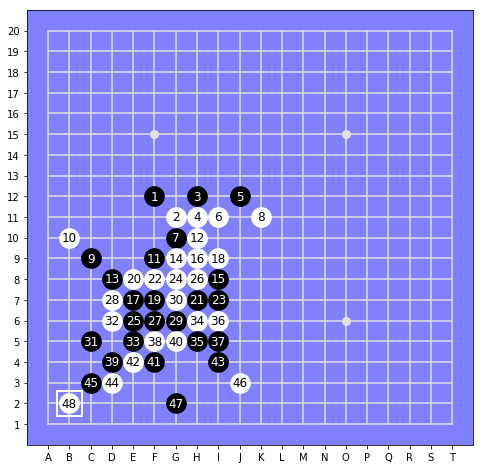

In [101]:
board = GomokuBoard(heuristics, N, disp_width=8, stones=stones)
board.display()

# Verify qvalues from file

In [102]:
from QFunction import heuristic_QF

In [103]:
policy = HeuristicGomokuPolicy(board, style=2)

In [104]:
qvalue = heuristic_QF(board, policy)
qvalue = qvalue[0].astype(np.float32)

In [105]:
from_file = q[idx].reshape(N_p, N_p)[1:-1].T[1:-1].T

In [106]:
(qvalue == from_file).all()

True